In [12]:
import pandas as pd
from scipy.stats import zscore
import arviz               # ver 0.11.0  !!
from arviz import geweke
import pymc3 as pm

In [13]:
path = "../00_data/penguins_lter.csv"

use = ['Sample Number', 'Species','Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex']
header = ['sample_number', 'species','culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']

species = {'Adelie Penguin (Pygoscelis adeliae)': 'Adelie',
       'Chinstrap penguin (Pygoscelis antarctica)': 'Chinstrap',
       'Gentoo penguin (Pygoscelis papua)': 'Gentoo'}

df_raw = pd.read_csv(path, usecols=use)
df_shrink = df_raw.set_axis(header, axis='columns').dropna()
df = df_shrink.replace(species)
print(df.shape)
df.head()

(334, 7)


sample_number species  culmen_length_mm  culmen_depth_mm  \
0              1  Adelie              39.1             18.7   
1              2  Adelie              39.5             17.4   
2              3  Adelie              40.3             18.0   
4              5  Adelie              36.7             19.3   
5              6  Adelie              39.3             20.6   

   flipper_length_mm  body_mass_g     sex  
0              181.0       3750.0    MALE  
1              186.0       3800.0  FEMALE  
2              195.0       3250.0  FEMALE  
4              193.0       3450.0  FEMALE  
5              190.0       3650.0    MALE

In [14]:
species_int = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}

x_std = zscore(df.body_mass_g.values)
y_std = zscore(df.culmen_length_mm.values)
g = df.species.replace(species_int).values.astype(int)


In [15]:
with pm.Model() as model:
    x_data = pm.Data('x', x_std)
    
    # prior (slope)
    a_mu = pm.Normal('a_mu', mu=0, sigma=100)
    a_sigma = pm.HalfCauchy('a_sigma', beta=0.25)
    g_num = max(g) + 1
    
    a_offset = pm.Normal('a_offset', mu=a_mu, sigma=a_sigma, shape=g_num)
    
    # prior (intercept)
    b_mu = pm.Normal('b_mu', mu=0, sigma=100)
    b_sigma = pm.HalfCauchy('b_sigma', beta=0.25)
    
    b_offset = pm.Normal('b_offset', mu=b_mu, sigma=b_sigma, shape=g_num)
    
    # likelihood
    y = pm.Normal('y', mu=a_offset[g]*x_data + b_offset[g], sigma=1.0, observed=y_std)

In [16]:
model.check_test_point()

a_mu              -5.52
a_sigma_log__     -1.14
a_offset           1.40
b_mu              -5.52
b_sigma_log__     -1.14
b_offset           1.40
y               -473.93
Name: Log-probability of test_point, dtype: float64

In [17]:
%%time

samples = 10000
burnin = 4000
num_chain = 4

with model:
    trace = pm.sample(draws=samples, tune=burnin, chains=num_chain, random_seed=1234, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_offset, b_sigma, b_mu, a_offset, a_sigma, a_mu]
Sampling 4 chains, 4,800 divergences: 100%|██████████| 56000/56000 [00:29<00:00, 1883.46draws/s]
There were 1189 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6524092583311634, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1503 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5708741035359676, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6351658372100847, but should be close to 0.8. Try to increase the number of tuning steps.
There were 95

CPU times: user 13.8 s, sys: 3.19 s, total: 17 s
Wall time: 42.2 s


/Users/seijmura/miniforge3/envs/juku/lib/python3.10/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_mu'}>,
        <AxesSubplot:title={'center':'a_mu'}>],
       [<AxesSubplot:title={'center':'a_sigma'}>,
        <AxesSubplot:title={'center':'a_sigma'}>],
       [<AxesSubplot:title={'center':'a_offset'}>,
        <AxesSubplot:title={'center':'a_offset'}>],
       [<AxesSubplot:title={'center':'b_mu'}>,
        <AxesSubplot:title={'center':'b_mu'}>],
       [<AxesSubplot:title={'center':'b_sigma'}>,
        <AxesSubplot:title={'center':'b_sigma'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>]], dtype=object)

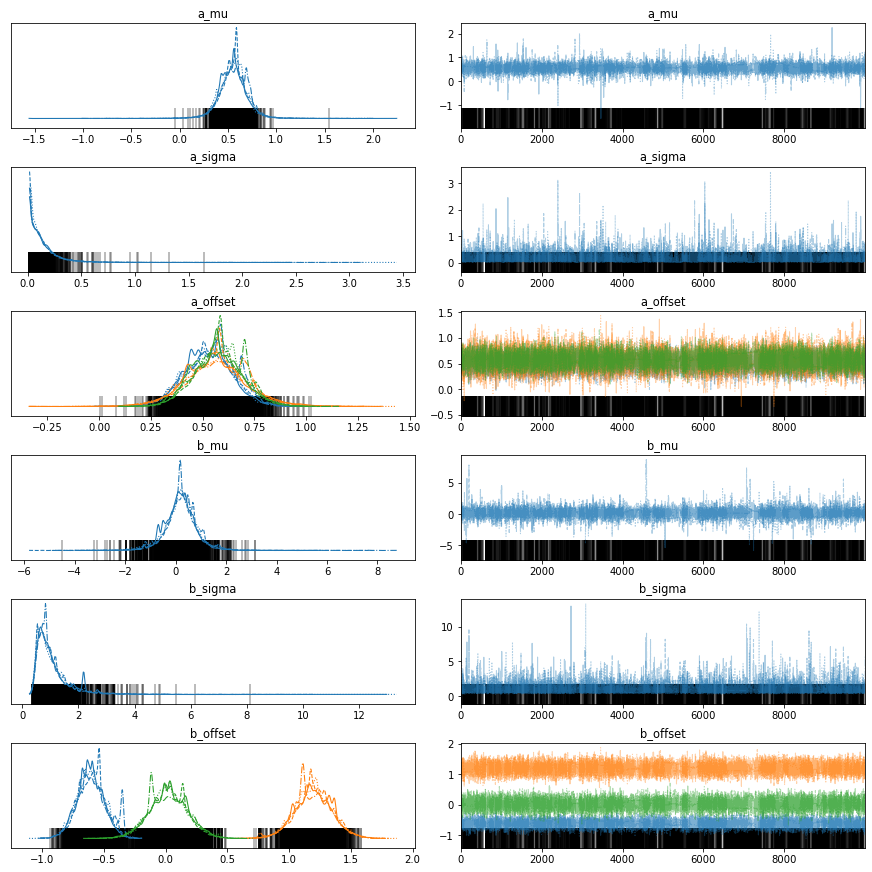

In [18]:
import arviz as az
az.plot_trace(trace, var_names=['a_mu','a_sigma','a_offset','b_mu','b_sigma','b_offset'])

In [19]:
for var_info in az.rhat(trace).values():
    print(var_info.name, var_info.values.round(3), sep=' ')

/Users/seijmura/miniforge3/envs/juku/lib/python3.10/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


a_mu 1.004
a_offset [1.005 1.004 1.005]
b_mu 1.006
b_offset [1.009 1.003 1.003]
a_sigma 1.012
b_sigma 1.004


In [20]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a_mu         0.557  0.153   0.278    0.816      0.003    0.002    2058.0   
a_offset[0]  0.531  0.120   0.311    0.758      0.004    0.003     853.0   
a_offset[1]  0.565  0.154   0.272    0.856      0.003    0.002    2188.0   
a_offset[2]  0.575  0.119   0.359    0.802      0.004    0.003    1046.0   
b_mu         0.203  0.714  -1.252    1.372      0.020    0.014    1270.0   
b_offset[0] -0.604  0.116  -0.789   -0.347      0.005    0.004     447.0   
b_offset[1]  1.196  0.151   0.904    1.476      0.003    0.002    1959.0   
b_offset[2]  0.023  0.157  -0.269    0.326      0.004    0.003    1486.0   
a_sigma      0.142  0.155   0.013    0.375      0.004    0.003    1369.0   
b_sigma      1.064  0.677   0.377    2.204      0.018    0.013    1426.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
a_mu         2058.0    1435.0    9211.0   1.00  
a_offset[0]   741.0     830.0    1156.0   1.00  
a_offset[1]  2188.0    1898.0   12338.0   1.00  
a_offset[2]  1046.0    1040.0    2547.0   1.01  
b_mu         1270.0    1105.0     878.0   1.01  
b_offset[0]   447.0     479.0     121.0   1.01  
b_offset[1]  1924.0    1905.0    5767.0   1.00  
b_offset[2]  1486.0    1485.0    1874.0   1.00  
a_sigma      1369.0     254.0      90.0   1.01  
b_sigma      1426.0    1054.0    4079.0   1.00

In [21]:
az.stats.waic(trace)

/Users/seijmura/miniforge3/envs/juku/lib/python3.10/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 40000 by 334 log-likelihood matrix

          Estimate       SE
elpd_waic  -342.20     2.89
p_waic        1.03        -